# Regressão com Árvores de Decisão

In [1]:
import numpy as np
import pandas as pd
# transform
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
# metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_validate
# graphics
import matplotlib.pyplot as plt
import seaborn as sns
# view all data frames collums
pd.set_option('display.max_columns', None)

### Carregamento dos Dados

In [2]:
complete_data_with_totalnet = pd.read_csv("data/integrated_processed_enem_anatel_ibge_2019.csv", encoding="latin_1")
complete_data_with_totalnet["densidade_total_internet_fixa"] = complete_data_with_totalnet[['fibra_optica', 'wifi', 'ethernet', 'lte',
                                                        'vsatelite', 'wimax', 'plc_eletrico', 'xdsl', 
                                                        'cable_modem', 'fwa_5g_fixed', 'atm_backbone',
                                                        'dth_satelite', 'hfc_tv_cabo', 'fr_frame_relay',
                                                        'mmds']].sum(axis=1)
complete_data_with_totalnet.sort_values(by="cod_municipio_ibge", inplace= True)
complete_data_with_totalnet = complete_data_with_totalnet[['cod_municipio_ibge', 'NO_MUNICIPIO_RESIDENCIA',
                                                          'UF', 'fibra_optica', 'wifi', 'ethernet', 'lte',
                                                          'vsatelite', 'wimax', 'plc_eletrico', 'xdsl', 
                                                          'cable_modem', 'fwa_5g_fixed', 'atm_backbone',
                                                          'dth_satelite', 'hfc_tv_cabo', 'fr_frame_relay',
                                                          'mmds', 'densidade_total_internet_fixa', 
                                                          'remuneracao_media', 'gini', 'pib', 
                                                          'pib_p_capta', 'media_idhm', 
                                                          'mean_grades_group_cities']]
complete_data_with_totalnet

,cod_municipio_ibge,NO_MUNICIPIO_RESIDENCIA,UF,fibra_optica,wifi,ethernet,lte,vsatelite,wimax,plc_eletrico,xdsl,cable_modem,fwa_5g_fixed,atm_backbone,dth_satelite,hfc_tv_cabo,fr_frame_relay,mmds,densidade_total_internet_fixa,remuneracao_media,gini,pib,pib_p_capta,media_idhm,mean_grades_group_cities
3852,1100015,Alta Floresta D'Oeste,RO,0,0,3,0,0,0,0,239,0,0,0,0,0,2,0,244,2030.28,0.472,4.956288e+08,21600.73,0.644038,493.009774
3853,1100023,Ariquemes,RO,0,0,47,0,0,0,0,0,0,8,0,0,0,3,0,58,2030.28,0.472,2.578830e+09,23908.38,0.644038,491.642412
3854,1100031,Cabixi,RO,3,129,2,0,3,0,0,75,0,0,0,0,0,0,0,212,2030.28,0.472,1.399594e+08,26347.78,0.644038,479.756641
3855,1100049,Cacoal,RO,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,6,2030.28,0.472,2.260644e+09,26483.95,0.644038,497.176007
3856,1100056,Cerejeiras,RO,0,0,0,0,0,0,0,644,0,0,0,0,0,4,0,648,2030.28,0.472,5.068545e+08,31051.55,0.644038,493.380822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124,5222005,Vianópolis,GO,0,0,0,0,74,0,0,606,0,0,0,0,0,0,0,680,2019.95,0.460,4.836633e+08,34888.79,0.694984,500.626357
1125,5222054,Vicentinópolis,GO,0,0,0,0,0,0,0,120,0,0,0,0,0,2,0,122,2019.95,0.460,3.423556e+08,39157.68,0.694984,477.479032
1126,5222203,Vila Boa,GO,83,142,0,0,0,0,0,0,0,0,0,0,0,1,0,226,2019.95,0.460,1.136685e+08,18419.78,0.694984,456.444022
1127,5222302,Vila Propício,GO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2019.95,0.460,2.069712e+08,35555.96,0.694984,468.682727


### Agregação dos Dados totais da Densidade do acesso a internet, agrupados po UF

In [3]:
internet_sum_uf = pd.DataFrame(complete_data_with_totalnet[["UF", "densidade_total_internet_fixa"]].groupby("UF").sum("densidade_total_internet_fixa"))
internet_sum_uf["UF"] = internet_sum_uf.index
internet_sum_uf.rename(columns={"densidade_total_internet_fixa" : "densidade_total_internet_uf"},inplace=True)
internet_sum_uf.rename_axis(mapper= "state", axis=0, inplace=True)
complete_data_with_totalnet_by_uf = pd.merge(left= complete_data_with_totalnet, 
                                             right= internet_sum_uf, left_on="UF", right_on="UF")
complete_data_with_totalnet_by_uf = complete_data_with_totalnet_by_uf[['cod_municipio_ibge', 'NO_MUNICIPIO_RESIDENCIA',
                                                          'UF', 'fibra_optica', 'wifi', 'ethernet', 'lte',
                                                          'vsatelite', 'wimax', 'plc_eletrico', 'xdsl', 
                                                          'cable_modem', 'fwa_5g_fixed', 'atm_backbone',
                                                          'dth_satelite', 'hfc_tv_cabo', 'fr_frame_relay',
                                                          'mmds', 'densidade_total_internet_fixa', 
                                                          "densidade_total_internet_uf",
                                                          'remuneracao_media', 'gini', 'pib', 
                                                          'pib_p_capta', 'media_idhm', 
                                                          'mean_grades_group_cities']]
complete_data_with_totalnet_by_uf

,cod_municipio_ibge,NO_MUNICIPIO_RESIDENCIA,UF,fibra_optica,wifi,ethernet,lte,vsatelite,wimax,plc_eletrico,xdsl,cable_modem,fwa_5g_fixed,atm_backbone,dth_satelite,hfc_tv_cabo,fr_frame_relay,mmds,densidade_total_internet_fixa,densidade_total_internet_uf,remuneracao_media,gini,pib,pib_p_capta,media_idhm,mean_grades_group_cities
0,1100015,Alta Floresta D'Oeste,RO,0,0,3,0,0,0,0,239,0,0,0,0,0,2,0,244,52057,2030.28,0.472,4.956288e+08,21600.73,0.644038,493.009774
1,1100023,Ariquemes,RO,0,0,47,0,0,0,0,0,0,8,0,0,0,3,0,58,52057,2030.28,0.472,2.578830e+09,23908.38,0.644038,491.642412
2,1100031,Cabixi,RO,3,129,2,0,3,0,0,75,0,0,0,0,0,0,0,212,52057,2030.28,0.472,1.399594e+08,26347.78,0.644038,479.756641
3,1100049,Cacoal,RO,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,6,52057,2030.28,0.472,2.260644e+09,26483.95,0.644038,497.176007
4,1100056,Cerejeiras,RO,0,0,0,0,0,0,0,644,0,0,0,0,0,4,0,648,52057,2030.28,0.472,5.068545e+08,31051.55,0.644038,493.380822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,5222005,Vianópolis,GO,0,0,0,0,74,0,0,606,0,0,0,0,0,0,0,680,305550,2019.95,0.460,4.836633e+08,34888.79,0.694984,500.626357
5566,5222054,Vicentinópolis,GO,0,0,0,0,0,0,0,120,0,0,0,0,0,2,0,122,305550,2019.95,0.460,3.423556e+08,39157.68,0.694984,477.479032
5567,5222203,Vila Boa,GO,83,142,0,0,0,0,0,0,0,0,0,0,0,1,0,226,305550,2019.95,0.460,1.136685e+08,18419.78,0.694984,456.444022
5568,5222302,Vila Propício,GO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,305550,2019.95,0.460,2.069712e+08,35555.96,0.694984,468.682727


## 1 - Construindo um modelo de Regressão com Árvore de Decisão Simples

### Separando os Dados independentes e dependentes

In [4]:
num_data_independent_uf = complete_data_with_totalnet_by_uf[['densidade_total_internet_uf', 
                                                    'gini', 'pib', 
                                                    'pib_p_capta', 'media_idhm']]
num_data_label_uf = complete_data_with_totalnet_by_uf['mean_grades_group_cities']

### Divisão dos dados em treino e teste, treino e avaliação do modelo:

In [5]:
from sklearn import tree
# Divisão dos dados em treino e teste
x_train, x_test, y_train, y_test = train_test_split(num_data_independent_uf, num_data_label_uf, 
                                                    train_size= 0.75, random_state=42)
model_tree = tree.DecisionTreeRegressor(max_depth= 7)
model_tree.fit(x_train, y_train)
y_predict = model_tree.predict(x_test)
print(f"O valor do Coeficiente de Regressão R²: {model_tree.score(x_test, y_test)}")
print(f"Raiz Quadrada o Erro Quadrático Médio: {round(np.sqrt(mean_squared_error(y_true= y_test, y_pred= y_predict)), 2)}")

O valor do Coeficiente de Regressão R²: 0.6909035034604682
Raiz Quadrada o Erro Quadrático Médio: 13.85


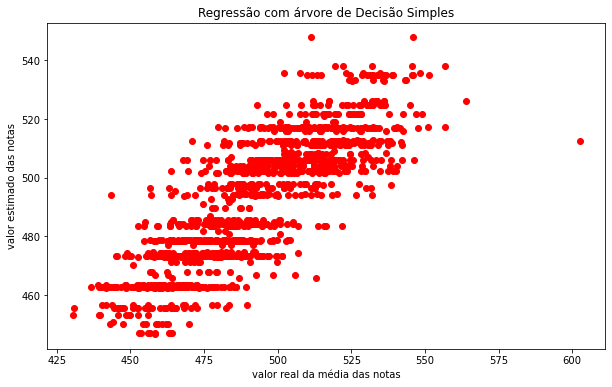

In [6]:
plt.figure(figsize=(10,6))
plt.scatter(x= y_test, y= y_predict, c="red")
plt.title("Regressão com árvore de Decisão Simples")
plt.xlabel("valor real da média das notas")
plt.ylabel("valor estimado das notas")
plt.show()

### Importância das variáveis

In [7]:
ols_importance = pd.DataFrame({"coeficientes" : abs(model_tree.feature_importances_.round(3))},
                              index= model_tree.feature_names_in_).sort_values(by= "coeficientes", 
                                                                              ascending=False)
ols_importance

,coeficientes
densidade_total_internet_uf,0.642
pib,0.163
media_idhm,0.114
pib_p_capta,0.062
gini,0.018


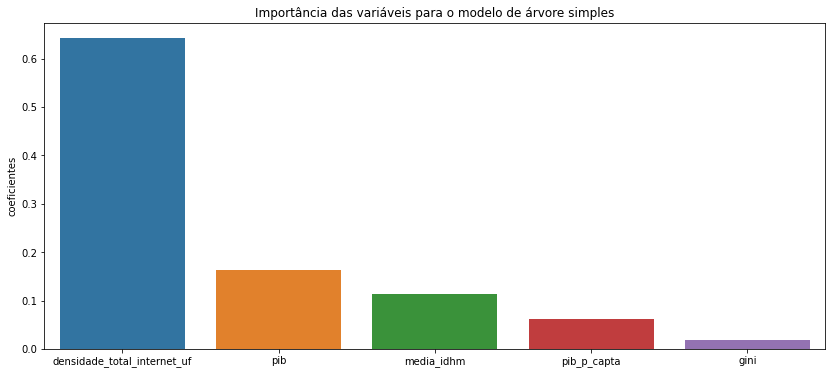

In [8]:
plt.figure(figsize=(14, 6))
sns.barplot(data=ols_importance, x=ols_importance.index, y="coeficientes")
plt.title("Importância das variáveis para o modelo de árvore simples")
plt.show()

### Treino e validação Cruzada. K-Fold Cross Validation

In [9]:
model_lm_cv = tree.DecisionTreeRegressor()
abs(np.mean(cross_val_score(model_lm_cv, X= num_data_independent_uf, y= num_data_label_uf, 
                            scoring= "r2", cv= 6)))

0.5791900202290737

## 2 - Modelos com ensemble - Floresta Rândomica

In [10]:
from sklearn.ensemble import RandomForestRegressor

### Treino do Modelo Random Forest e avaliação

In [11]:
# Divisão dos dados em treino e teste
x_train, x_test, y_train, y_test = train_test_split(num_data_independent_uf, num_data_label_uf, 
                                                    train_size= 0.75, random_state=42)

model_rf = RandomForestRegressor(max_depth= 9, random_state=42)
model_rf.fit(x_train, y_train)
y_predict = model_rf.predict(x_test)
print(f"O valor do Coeficiente de Regressão R²: {model_rf.score(x_test, y_test)}")
print(f"Raiz Quadrada o Erro Quadrático Médio: {round(np.sqrt(mean_squared_error(y_true= y_test, y_pred= y_predict)), 2)}")

O valor do Coeficiente de Regressão R²: 0.7107070859877298
Raiz Quadrada o Erro Quadrático Médio: 13.4


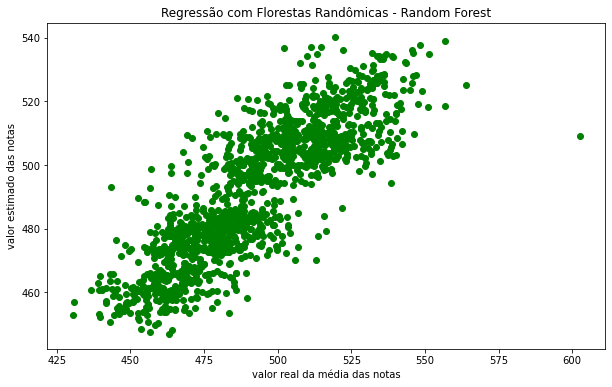

In [12]:
plt.figure(figsize=(10,6))
plt.scatter(x= y_test, y= y_predict, c="green")
plt.title("Regressão com Florestas Randômicas - Random Forest")
plt.xlabel("valor real da média das notas")
plt.ylabel("valor estimado das notas")
plt.show()

### Importância das variáveis - Random Forest

In [13]:
rf_importance = pd.DataFrame({"coeficientes" : abs(model_rf.feature_importances_.round(3))},
                              index= model_rf.feature_names_in_).sort_values(by= "coeficientes", 
                                                                              ascending=False)
rf_importance

,coeficientes
densidade_total_internet_uf,0.597
pib,0.189
media_idhm,0.098
pib_p_capta,0.096
gini,0.020


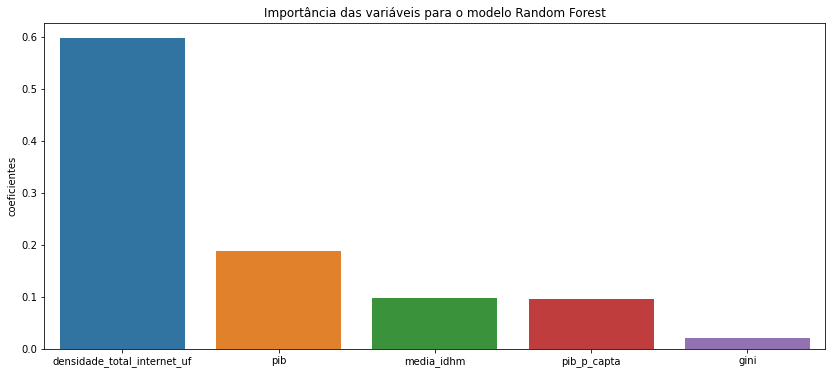

In [14]:
plt.figure(figsize=(14, 6))
sns.barplot(data=rf_importance, x= rf_importance.index, y="coeficientes")
plt.title("Importância das variáveis para o modelo Random Forest")
plt.show()

### Treino e validação Cruzada com Random Forest

In [15]:
model_rf_cv = RandomForestRegressor(max_depth= 3)
abs(np.mean(cross_val_score(model_rf_cv, 
                            X= num_data_independent_uf, 
                            y= num_data_label_uf,
                            scoring= "r2", cv= 2)))

0.5647760414072955

### Teste Shapiro para aderência à normalidade

In [16]:
from scipy import stats
residuals = y_test - y_predict
stats.shapiro(residuals)

ShapiroResult(statistic=0.9877464175224304, pvalue=1.9393939787448744e-09)

### FIM